<a href="https://colab.research.google.com/github/zaynabmourtada/Handwritten-Digit-Recognizer/blob/main/learn_nnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Neural Network Code

CIS 481/581 Computational Learning

Instructor: Luis E Ortiz

Student: Zaynab Mourtada

In [ ]:
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
import warnings

from collections import defaultdict

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import ParameterGrid, KFold, train_test_split

from numpy.random import default_rng

In [ ]:
rng = default_rng()

def random_uniform(n,m,R=[-1.0,1.0]):
  a, b = R[0], R[1]
  return (b - a) * rng.random((n,m)) + a

def sigmoid(x):
  return 1.0 / (1.0 + np.exp(-x))

def deriv_sigmoid(x):
  return sigmoid(x) * (1.0 - sigmoid(x))

def squared_error(y_true,y_pred):
  return 0.5 * (y_true - y_pred) ** 2

def deriv_squared_error(y_true,y_pred):
  return y_pred - y_true

def indicator(p):
  return p.astype(int)

def error_rate(y_true, y_pred):
  return 1.0 - np.mean(indicator(y_true == y_pred))

def identity(x):
  return x

def deriv_identity(x):
  return np.ones(x.shape)

In [ ]:
def make_nunits(n,K,L,N):
  nunits = [n]
  for l in range(L):
    nunits.append(N)
  nunits.append(K)
  return nunits

def time_nnet(nunits):
  t = 0
  for l in range(len(nunits)-1):
    t += (nunits[l] + 1) * nunits[l+1]
  return t

In [ ]:
MAX_ITERS = 50
MAX_NHIDU = 2**9
MAX_NHIDL = 2**2
MAX_M = 2000

n= 1024
K = 10

MAX_NUNITS = make_nunits(n,K,MAX_NHIDL,MAX_NHIDU)
MAX_NNET_TIME = time_nnet(MAX_NUNITS)

MAX_TIME = MAX_M * MAX_NNET_TIME * MAX_ITERS


In [ ]:
class NNetBaseFunction:
    def __init__(self, f=None,df=None):
      self.f = f
      self.df = df

    def deepcopy(self):
      return NNetBaseFunction(f=self.f, df=self.df)

In [ ]:
class NNetActivation(NNetBaseFunction):
    def __init__(self, f=sigmoid,df=deriv_sigmoid):
      super().__init__(f=f,df=df)

    def deepcopy(self):
      return NNetActivation(f=self.f, df=self.df)

In [ ]:
class NNetLoss(NNetBaseFunction):
  def __init__(self, f=squared_error,df=deriv_squared_error):
    super().__init__(f=f,df=df)

  def deepcopy(self):
    return NNetLoss(f=self.f, df=self.df)

In [ ]:
class NNetMetric(NNetBaseFunction):
  def __init__(self, f=error_rate):
    super().__init__(f=f,df=None)

  def deepcopy(self):
    return NNetMetric(f=self.f)

In [ ]:
class NNetLayer:
  def __init__(self,n_in=1,n_out=1,W=None,
               unit=NNetActivation(), initializer=random_uniform):
    self.n_in = n_in
    self.n_out = n_out
    if initializer is None:
      initializer =  lambda n, m : np.zeros((n,m))
    self.initializer = initializer
    if W is None:
      W = self.initializer(n_out,n_in+1)
    else:
      self.n_in, self.n_out = W.shape[1]-1, W.shape[0]
    self.W = W
    self.unit = unit

  def ds(self, x):
    return self.unit.df(x)

  def deepcopy(self):
    return NNetLayer(n_in=self.n_in,n_out=self.n_out,W=self.W.copy(),
                     unit=self.unit)

  def copy_layer(self, layer):
    self.W[:] = layer.W[:]
    return self

  # assumes x[0,:] = +1
  def aggregation_with_dummy_input(self, x):
    return np.matmul(self.W,x)

  def aggregation(self, x):
    if x.shape[0] == self.W.shape[1]:
      x_tmp = x
    else:
      x_tmp = np.ones(self.W.shape[1],x.shape[1])
      x_tmp[1:,:] = x
    return self.aggregation_with_dummy_input(x_tmp)

  def activation(self, x):
    return self.unit.f(self.aggregation(x))

  def set_x(self, x):
    return x

  def set_y(self, y):
    return y

  def get_y(self):
    return None


In [ ]:
class NNetIdentityLayer (NNetLayer):
  def __init__(self,n_in=1,n_out=1,W=None):
    super().__init__(n_in=n_in,n_out=n_out,W=W,
                     unit=NNetActivation(identity,deriv_identity))

In [ ]:
class NNetLayerProp(NNetLayer):
  def __init__(self,n_in=1,n_out=1,W=None,
               unit=NNetActivation(sigmoid,deriv_sigmoid),m=1):
    super().__init__(n_in=n_in,n_out=n_out,W=W,unit=unit)
    # self.y = np.ones((n_out+1,m))
    # self.y[1:,:] = 0
    # self.delta = np.zeros((n_out+1,m))
    self.x = None
    self.y = None
    self.delta = None

  def deepcopy(self):
    copy = super().deepcopy()
    # Input is not "stored" by layer
    copy.x = self.x
    copy.y = None if self.y is None else self.y.copy()
    copy.delta = None if self.delta is None else self.delta.copy()
    return copy

  def set_x(self, x):
    self.x = x
    return x

  def set_y(self, y):
    self.y = y
    return y

  def set_delta(self, delta):
    self.delta = delta
    return delta

  def get_x(self):
    return self.x

  def get_y(self):
    return self.y

  def get_delta(self):
    return self.delta

  def dW(self):
    return np.matmul(self.delta,self.x.T)

In [ ]:
class NNetInputLayerProp(NNetLayerProp):
  def __init__(self,n_in=1,n_out=1,W=None,m=1):
    super().__init__(n_in=n_in,n_out=n_out,W=W,unit=NNetActivation(identity,deriv_identity))
    self.y = None

  def deepcopy(self):
    obj = super().deepcopy()
    obj.y = None if self.y is None else self.y.deepcopy()
    return obj


In [ ]:
class NNetOptimizer:
  def __init__(self,loss=NNetLoss(),metric=NNetMetric()):
    self.loss = loss
    self.metric = metric
    self.best_nnet = None
    self.last_nnet = None
    self.train_err = []
    self.test_err = []
    return self

  def deepcopy(self):
    opt = NNetOptimizer(loss=self.loss.deepcopy(),metric=self.metric.deepcopy())
    opt.best_nnet = None if self.best_nnet is None else self.best_nnet.deepcopy()
    opt.last_nnet = None if self.best_nnet is None else self.last_nnet.deepcopy()
    opt.train_err = self.train_err.deepcopy()
    opt.test_err = self.test_err.deepcopy()
    return opt

  def run(self,nnet,X,y):
    return self.best_nnet

In [ ]:
class NNet:
  def __init__(self, nunits=[0,0], unit=NNetActivation(sigmoid,deriv_sigmoid),
               output_unit=None, Layer=NNetLayerProp, InputLayer=NNetInputLayerProp):
    self.nunits = nunits
    self.unit = unit
    self.output_unit = unit if output_unit is None else output_unit
    self.nlayers = len(nunits)
    self.layer = []
    self.layer.append(InputLayer(n_in=1,n_out=nunits[0]))

    for l in range(1,self.nlayers-1):
      self.layer.append(Layer(n_in=nunits[l-1],n_out=nunits[l],unit=unit))

    self.layer.append(Layer(n_in=nunits[-2],n_out=nunits[-1],
                                unit=self.output_unit))

  def copy(self, nnet_copy=None, Layer=NNetLayerProp, InputLayer=NNetInputLayerProp):
    if nnet_copy is None:
      nnet_copy = NNet(nunits=self.nunits,unit=self.unit,output_unit=self.output_unit, Layer=Layer, InputLayer=InputLayer)
    nnet_copy.copy_layers(self)
    return nnet_copy

  def deepcopy(self, nnet_copy=None):
    nnet_copy = self.copy(nnet_copy=nnet_copy)

    nnet_copy.nunits = copy.deepcopy(self.nunits)
    nnet_copy.unit = self.unit.deepcopy()
    nnet_copy.output_unit = self.output_unit.deepcopy()

    for l in range(1,self.nlayers):
      nnet_copy.layer[l] = self.layer[l].deepcopy()

    return nnet_copy

  def copy_layers(self, nnet_copy_from):
    for l in range(self.nlayers):
      self.layer[l].copy_layer(nnet_copy_from.layer[l])
    return self

  def error(self, X, y, loss=squared_error, metric=None):
    output = self.forwardprop(X.T)
    err = np.mean(loss(y.T, output))
    err_rate = 1.0 if metric is None else metric(y.T,output)
    return err, err_rate

  def forwardprop(self,X):
    m = X.shape[1]
    out_vals = np.ones((X.shape[0]+1,m))
    out_vals[1:,:] = X
    self.layer[0].set_y(out_vals)

    for l in range(1,self.nlayers):
      self.layer[l].set_x(self.layer[l-1].get_y())
      del out_vals
      out_vals = np.ones((self.nunits[l]+1,m))
      out_vals[1:,:] = self.layer[l].activation(self.layer[l].get_x())
      self.layer[l].set_y(out_vals)

    return out_vals[1:,:]

  def backprop(self,X,y,dE='deriv_squared_error'):
    net_output = self.forwardprop(X)

    layer = self.layer[self.nlayers-1]
    layer.set_delta(layer.ds(net_output) * dE(y,net_output))

    for l in range(self.nlayers-1,1,-1):
      next_layer = self.layer[l]
      layer = self.layer[l-1]
      x = layer.get_y()[1:,:]
      d = next_layer.delta
      layer.set_delta(layer.ds(x) * np.matmul(next_layer.W[:,1:].T,d))

    dW = []
    for l in range(self.nlayers):
      dW.append(None)

    for l in range(self.nlayers-1,0,-1):
      dW[l] = self.layer[l].dW()

    return dW

  def fit(self, X, y, X_test=None, y_test=None, optimizer=None, verbose=0):
    if optimizer is None:
      optimizer = NNetGDOptimizer(loss=NNetLoss())

    best_nnet = optimizer.run(self,X,y,X_test,y_test,verbose)

    self.copy_layers(best_nnet)

    return self


In [ ]:
class NNetGDOptimizer(NNetOptimizer):
  def __init__(self,loss=NNetLoss(),max_iters=100, learn_rate=1, reg_param=0,
               change_thresh=1e-4, change_err_thresh=1e-6,metric=NNetMetric()):
    super().__init__(loss=loss,metric=metric)
    self.max_iters = max_iters
    self.learn_rate = learn_rate
    self.reg_param = reg_param
    self.change_thresh = change_thresh
    self.change_err_thresh = change_err_thresh

  def deepcopy(self):
    opt = super().deepcopy()
    return NNetGDOptimizer(loss=opt.loss, max_iters=self.max_iters, learn_rate=self.learn_rate, reg_param=self.reg_param,
               change_thresh=self.change_thresh, change_err_thresh=self.change_err_thresh,metric=opt.metric)

  def run(self, nnet, X, y, X_test=None, y_test=None, verbose=0):

    m = X.shape[0]
    eval_test = X_test is not None and y_test is not None
    new_nnet = NNet(nunits=nnet.nunits,unit=nnet.unit,output_unit=nnet.output_unit,Layer=NNetLayerProp,InputLayer=NNetInputLayerProp)
    new_nnet.copy_layers(nnet)

    t = 0
    max_change = math.inf
    min_change_err = math.inf

    train_err = []
    test_err = []

    err, err_rate = new_nnet.error(X, y, loss=self.loss.f, metric=self.metric.f)
    if verbose > 0:
      print((err,err_rate))
    min_err, min_err_rate = err, err_rate

    if eval_test:
      cv_err,cv_err_rate = new_nnet.error(X_test, y_test, loss=self.loss.f, metric=self.metric.f)

    best_nnet = nnet.deepcopy()
    best_nnet.copy_layers(new_nnet)

    while min_change_err > self.change_err_thresh and max_change > self.change_thresh and t < self.max_iters:
      if verbose > 0:
        print(t)
        print("Backprop...")

      dW = new_nnet.backprop(X.T, y.T,dE=self.loss.df)

      if verbose > 0:
        print("done.")
        print("Update...")

      max_change = 0

      for l in range(new_nnet.nlayers-1,0,-1):
        delta_W = self.learn_rate * (dW[l] / m + self.reg_param * new_nnet.layer[l].W)
        new_nnet.layer[l].W[:] = new_nnet.layer[l].W[:] - delta_W[:]
        max_change = max(max_change, np.max(np.absolute(delta_W)))

      del dW[:]

      if verbose > 0:
        print("done.")

      last_err = err
      err,err_rate = new_nnet.error(X, y, loss=self.loss.f, metric=self.metric.f)
      if verbose > 0:
        print((err,err_rate))
      min_change_err = np.absolute(err-last_err)


      if verbose > 0:
        print("max_change")
        print(max_change)

      if eval_test:
        cv_err,cv_err_rate = new_nnet.error(X_test, y_test, loss=self.loss.f, metric=self.metric.f)

      if verbose > 0:
        if eval_test:
          print("(test_err,test_err_rate)")
          print((cv_err,cv_err_rate))

      if err < min_err:
        min_err = err
        min_err_rate = err_rate
        best_nnet.copy_layers(new_nnet)

      t += 1

      train_err.append([err, err_rate])
      if eval_test:
        test_err.append([cv_err, cv_err_rate])

    if verbose > 0:
      if eval_test:
        print("(best_train_err,best_train_err_rate)")
        print((min_err,min_err_rate))

    self.train_err = train_err
    self.test_err = test_err

    return best_nnet

In [ ]:
# Implemented by Zaynab Mourtada
def perception_model(learning_rate):
  nunits=[n,K]
  nnet_time = time_nnet(nunits)
  R = min(1000, math.ceil(MAX_TIME / (m * nnet_time)))
  nnet = NNet(nunits=nunits)
  optimizer = NNetGDOptimizer(learn_rate=learning_rate, max_iters=R, metric=nnet_metric)
  return nnet, optimizer

In [ ]:
# Implemented by Zaynab Mourtada
def dnn_model(depth, learning_rate=1):
  nunits = [n] + [64] * depth + [K]
  nnet = NNet(nunits=nunits)
  nnet_time = time_nnet(nunits)
  R = min(1000, math.ceil(MAX_TIME / (m * nnet_time)))
  optimizer = NNetGDOptimizer(learn_rate=learning_rate, max_iters=R, metric=nnet_metric)
  return nnet, optimizer

In [ ]:
# Implemented by Zaynab Mourtada
def dnn_two_layer_model(learning_rate):
  nunits = [n, 256, 64, K]
  nnet = NNet(nunits=nunits)
  nnet_time = time_nnet(nunits)
  R = min(1000, math.ceil(MAX_TIME / (m * nnet_time)))
  optimizer = NNetGDOptimizer(learn_rate=learning_rate, max_iters=R, metric=nnet_metric)
  return nnet, optimizer

In [ ]:
# Implemented by Zaynab Mourtada
def cross_validate_model(model_fn, param_grid, X, y, name="Model"):
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    best_average_error = float('inf')
    best_params = None
    all_errors = []

    for params in param_grid:
        print(f"Evaluating {name} with params: {params}")
        fold_errors = []
        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            nnet, optimizer = model_fn(*params)
            nnet.fit(X_train, y_train, X_val, y_val, optimizer=optimizer, verbose=0)

            y_pred = nnet.forwardprop(X_val.T)
            pred_labels = np.argmax(y_pred, axis=0).reshape(-1, 1)
            true_labels = np.argmax(y_val, axis=1).reshape(-1, 1)

            err = error_rate(true_labels, pred_labels)
            fold_errors.append(err)

        avg_err = np.mean(fold_errors)
        all_errors.append((params, avg_err))
        print(f"Average CV Error for {params}: {avg_err:.4f}")

        if avg_err < best_average_error:
            best_average_error = avg_err
            best_params = params

    if "Perceptron" in name or "Two-Layer" in name:
        xlabel = "Learning Rate"
    elif "DNN" in name:
        xlabel = "Depth"
    else:
        xlabel = "Hyperparameter"

    # CV Error Curve
    plt.figure(figsize=(8, 4))
    x_vals = range(len(param_grid))
    y_vals = [e[1] for e in all_errors]
    labels = [str(p[0]) for p in param_grid]
    plt.plot(x_vals, y_vals, marker='o', label=f"{name} CV Error")
    plt.xticks(x_vals, labels)
    plt.xlabel(xlabel)
    plt.ylabel("CV Misclassification Error")
    plt.title(f"{name} - CV Error vs {xlabel}")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"\n Best {name} Params: {best_params} with CV Error: {best_average_error:.4f}\n")
    return best_params

    print(f"\n Best {name} Params: {best_params} with CV Error: {best_average_error:.4f}\n")
    return best_params

In [ ]:
# Implemented by Zaynab Mourtada
def train_evaluate_model(nnet, optimizer, X, y, X_test, y_test, model_name):
  best_nnet = nnet.fit(X, y, X_test, y_test, optimizer=optimizer, verbose=1)
  train_err = np.array(optimizer.train_err)
  test_err = np.array(optimizer.test_err)

  # Printing all values
  print(f"\n>>> {model_name} - ALL Training Proxy Error:")
  print(train_err[:, 0])
  print(f"\n>>> {model_name} - ALL Test Proxy Error:")
  print(test_err[:, 0])

  print(f"\n>>> {model_name} - ALL Training Misclassification Error:")
  print(train_err[:, 1])
  print(f"\n>>> {model_name} - ALL Test Misclassification Error:")
  print(test_err[:, 1])

  # Plot Proxy Error
  plt.figure(figsize=(8, 4))
  plt.plot(train_err[:, 0], label="Training Proxy Error", color='red')
  plt.plot(test_err[:, 0], label="Testing Proxy Error", color='purple')
  plt.title(f"Proxy Error (Gradient Descent Fitting) for {model_name}")
  plt.xlabel("Iterations")
  plt.ylabel("Proxy Error (MSE)")
  plt.ylim(0.00, 0.10)
  plt.legend()
  plt.grid(True)
  plt.show()

  # Plot Misclassification Error
  plt.figure(figsize=(8, 4))
  plt.plot(train_err[:, 1], label="Training Misclassification Error", color='blue')
  plt.plot(test_err[:, 1], label="Testing Misclassification Error", color='orange')
  plt.title(f"Misclassification Error for {model_name}")
  plt.xlabel("Iterations")
  plt.ylabel("Misclassification Error")
  plt.ylim(min(train_err[:, 1].min(), test_err[:, 1].min()) - 0.01,
             max(train_err[:, 1].max(), test_err[:, 1].max()) + 0.01)
  plt.legend()
  plt.grid(True)
  plt.show()

  print(f"Final Test Error for {model_name}: {test_err[-1, 1]}")


6A: Perceptron Output Unit Weights


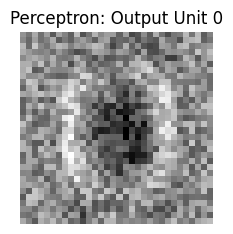

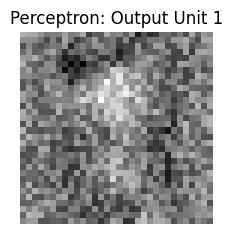

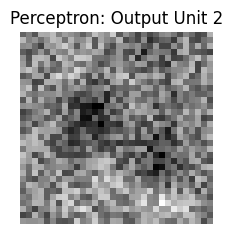

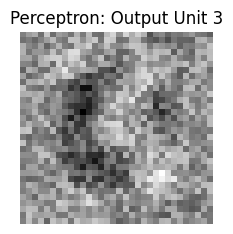

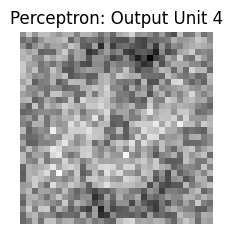

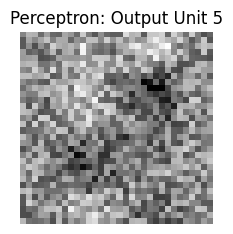

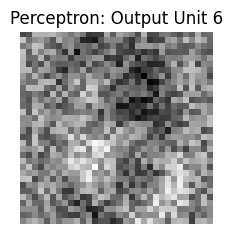

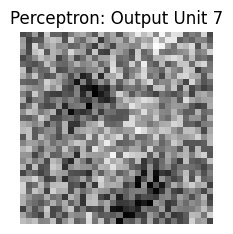

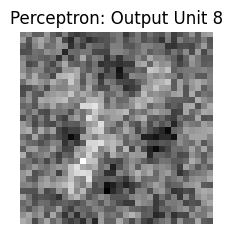

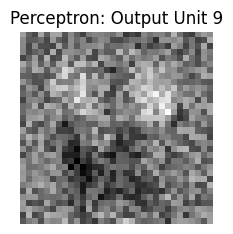


6B: DNN Hidden Layer 1 Weights (10 random units)


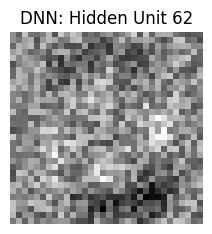

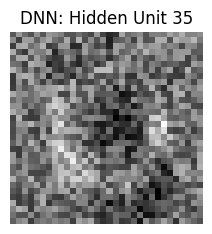

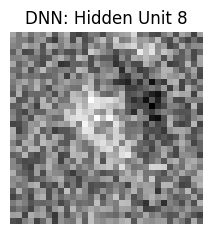

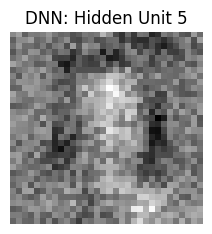

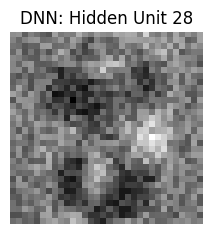

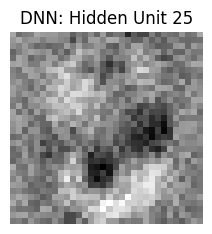

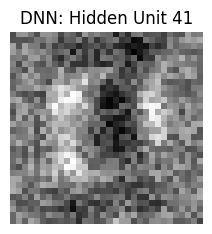

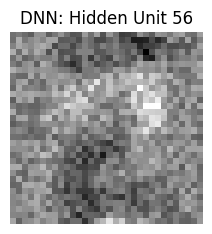

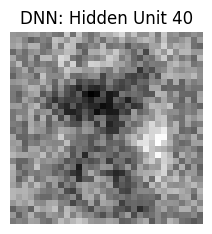

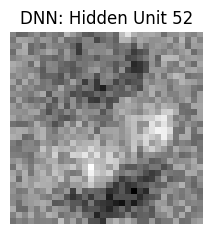


6C: Two-Layer DNN Hidden Layer 1 Weights (10 random units)


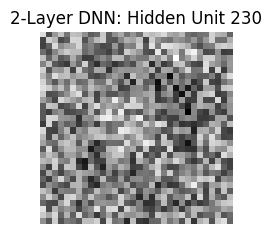

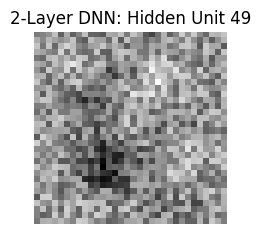

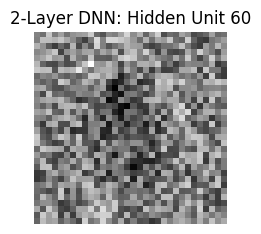

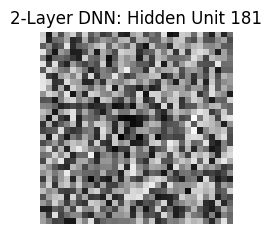

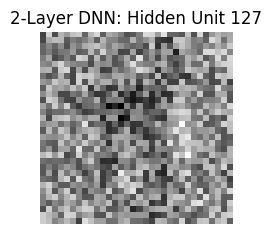

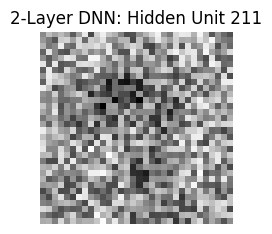

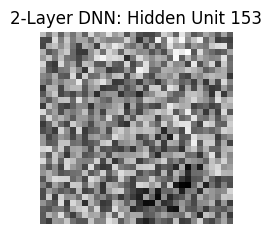

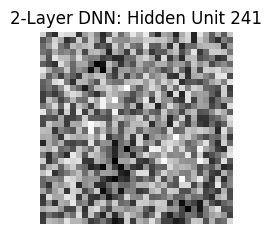

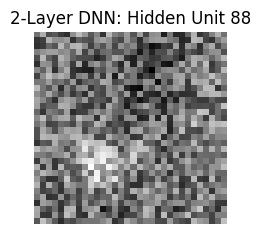

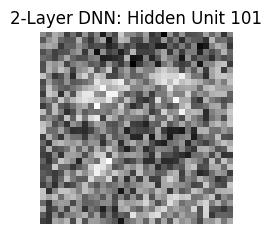

In [ ]:
# Implemented by Zaynab Mourtada
print("\n6A: Perceptron Output Unit Weights")
for i in range(10):
    plt.figure(figsize=(2.5, 2.5))
    weights = nnet_p.layer[-1].W[i, 1:].reshape(32, 32)
    plt.imshow(weights, cmap='gray')
    plt.title(f'Perceptron: Output Unit {i}')
    plt.axis('off')
    filename = f'/content/perceptron_weights/unit_{i}.png'
    plt.savefig(filename)
    plt.show()
    plt.close()

print("\n6B: DNN Hidden Layer 1 Weights (10 random units)")
W_dnn = nnet_dnn.layer[1].W[:, 1:]
random_units_dnn = np.random.choice(W_dnn.shape[0], 10, replace=False)
for i in random_units_dnn:
    plt.figure(figsize=(2.5, 2.5))
    plt.imshow(W_dnn[i].reshape(32, 32), cmap='gray')
    plt.title(f'DNN: Hidden Unit {i}')
    plt.axis('off')
    filename = f'/content/dnn_weights/unit_{i}.png'
    plt.savefig(filename)
    plt.show()
    plt.close()

print("\n6C: Two-Layer DNN Hidden Layer 1 Weights (10 random units)")
W_2l = nnet_2l.layer[1].W[:, 1:]
random_units_2l = np.random.choice(W_2l.shape[0], 10, replace=False)
for i in random_units_2l:
    plt.figure(figsize=(2.5, 2.5))
    plt.imshow(W_2l[i].reshape(32, 32), cmap='gray')
    plt.title(f'2-Layer DNN: Hidden Unit {i}')
    plt.axis('off')
    filename = f'/content/two_layer_dnn_weights/unit_{i}.png'
    plt.savefig(filename)
    plt.show()
    plt.close()



In [ ]:
if __name__ == '__main__':
  D = np.loadtxt('/content/drive/My Drive/CIS 481 Project 2/optdigits_train.dat')
  D_test = np.loadtxt('/content/drive/My Drive/CIS 481 Project 2/optdigits_test.dat')
  D_trial = np.loadtxt('/content/drive/My Drive/CIS 481 Project 2/optdigits_trial.dat')

Sample trial labels (true): [1. 2. 3. 4. 5. 6. 7. 8. 9. 0.]


In [ ]:
  # Implemented by Zaynab Mourtada
  def evaluate_on_trial(nnet, X_trial, y_trial, name='Model'):
    y_pred_trial = nnet.forwardprop(X_trial.T)
    y_pred_label = np.argmax(y_pred_trial, axis=0).reshape(-1,1)
    y_true_label = y_trial.astype(int).reshape(-1, 1)

    trial_error = error_rate(y_true_label, y_pred_label)
    print(f"{name} - Trial Set Misclassification Error: {trial_error:.4f}")
    return trial_error

In [ ]:
  m, n = D.shape[0], D.shape[1]-1

  X = D[:,:-1].reshape(m,n)
  y = D[:,-1].reshape(m,1)

  out_enc = LabelBinarizer()
  y_ohe = out_enc.fit_transform(y)

  K = y_ohe.shape[1]

  m_test = D_test.shape[0]

  X_test = D_test[:,:-1].reshape(m_test,n)
  y_test = D_test[:,-1].reshape(m_test,1)

  y_test_ohe = out_enc.transform(y_test)

  m_trial = D_trial.shape[0]

  X_trial = D_trial[:,:-1].reshape(m_trial,n)
  y_trial = D_trial[:,-1].reshape(m_trial,1)

  y_trial_ohe = out_enc.transform(y_trial)

[4.]


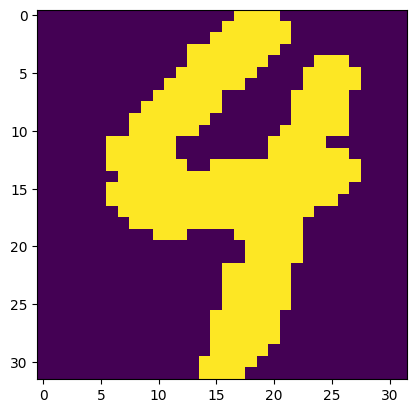

In [ ]:
  plt.imshow(X[53,:].reshape(32,32))
  print(y[53])

[2.]


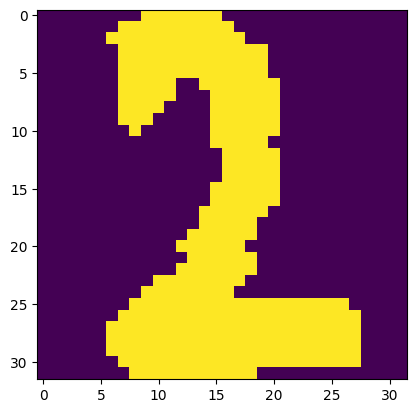

In [ ]:
  plt.imshow(X_trial[1,:].reshape(32,32))
  print(y_trial[1])

In [ ]:
  def nnet_error_rate(y_true, y_pred):
    y_pred_label = np.argmax(y_pred,axis=0).reshape(-1,1)
    y_true_label = out_enc.inverse_transform(y_true.T).reshape(-1,1)
    return error_rate(y_true_label, y_pred_label)

In [ ]:
  nnet_metric = NNetMetric(f=nnet_error_rate)

Evaluating Perceptron with params: [1]
Average CV Error for [1]: 0.0781
Evaluating Perceptron with params: [4]
Average CV Error for [4]: 0.0734
Evaluating Perceptron with params: [16]
Average CV Error for [16]: 0.0512
Evaluating Perceptron with params: [64]


<ipython-input-3-8b906e22452d>:8: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))


Average CV Error for [64]: 0.3158
Evaluating Perceptron with params: [256]
Average CV Error for [256]: 0.0636


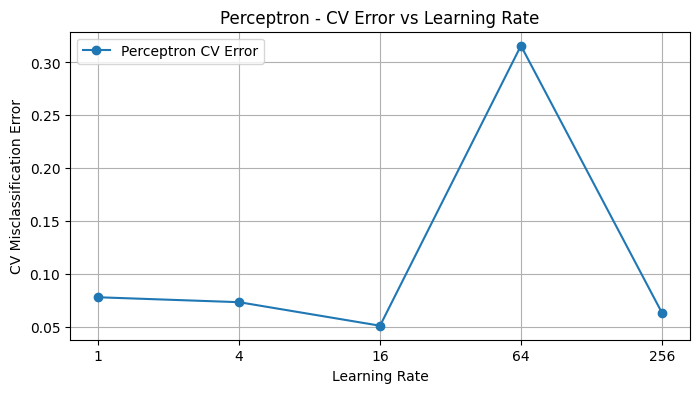


 Best Perceptron Params: [16] with CV Error: 0.0512



In [ ]:
  # Implemented by Zaynab Mourtada
  perceptron_lr = [[lr] for lr in [4**0, 4**1, 4**2, 4**3, 4**4]]
  best_perceptron_params = cross_validate_model(perception_model, perceptron_lr, X, y_ohe, name="Perceptron")

Evaluating DNN with params: [1]
Average CV Error for [1]: 0.0688
Evaluating DNN with params: [2]
Average CV Error for [2]: 0.0719
Evaluating DNN with params: [3]
Average CV Error for [3]: 0.0657
Evaluating DNN with params: [4]


<ipython-input-3-8b906e22452d>:8: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))


Average CV Error for [4]: 0.0895


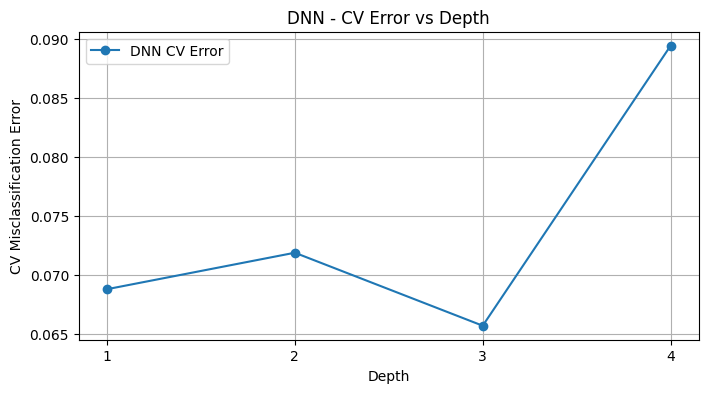


 Best DNN Params: [3] with CV Error: 0.0657



In [ ]:
  # Implemented by Zaynab Mourtada
  dnn_depth = [[d] for d in [1, 2, 3, 4]]
  best_dnn_params = cross_validate_model(dnn_model, dnn_depth, X, y_ohe, name="DNN")

Evaluating Two-Layer DNN with params: [0.015625]
Average CV Error for [0.015625]: 0.7037
Evaluating Two-Layer DNN with params: [0.0625]
Average CV Error for [0.0625]: 0.2968
Evaluating Two-Layer DNN with params: [0.25]
Average CV Error for [0.25]: 0.1256
Evaluating Two-Layer DNN with params: [1]
Average CV Error for [1]: 0.0729
Evaluating Two-Layer DNN with params: [4]
Average CV Error for [4]: 0.0522


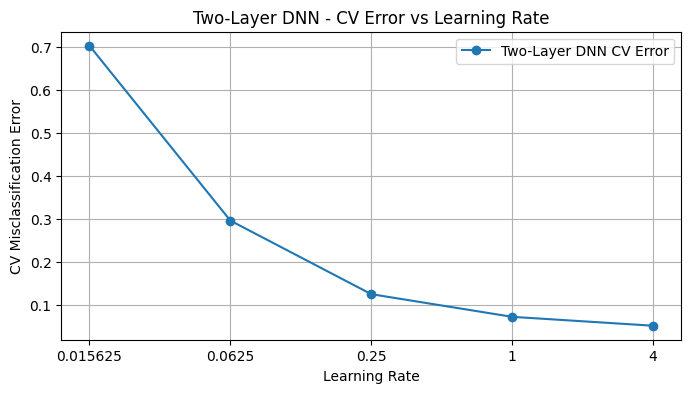


 Best Two-Layer DNN Params: [4] with CV Error: 0.0522



In [ ]:
  # Implemented by Zaynab Mourtada
  two_layer_lr = [[lr] for lr in [4**-3, 4**-2, 4**-1, 4**0, 4**1]]
  best_two_layer_params = cross_validate_model(dnn_two_layer_model, two_layer_lr, X, y_ohe, name="Two-Layer DNN")

In [ ]:
  # Implemented by Zaynab Mourtada
  nnet_p, opt_p = perception_model(*best_perceptron_params)
  train_evaluate_model(nnet_p, opt_p, X, y_ohe, X_test, y_test_ohe, model_name="Perceptron (Final)")

Streaming output truncated to the last 5000 lines.
done.
Update...
done.
(np.float64(0.004515821346049813), np.float64(0.04136504653567741))
max_change
0.00514286353140018
(test_err,test_err_rate)
(np.float64(0.0058115230206125254), np.float64(0.06553911205073992))
477
Backprop...
done.
Update...
done.
(np.float64(0.004510305456628407), np.float64(0.04136504653567741))
max_change
0.005140850042465474
(test_err,test_err_rate)
(np.float64(0.005807511974243131), np.float64(0.06448202959830862))
478
Backprop...
done.
Update...
done.
(np.float64(0.004504837645460396), np.float64(0.04136504653567741))
max_change
0.005138818502711521
(test_err,test_err_rate)
(np.float64(0.005803554074038327), np.float64(0.06448202959830862))
479
Backprop...
done.
Update...
done.
(np.float64(0.004499415939719181), np.float64(0.04136504653567741))
max_change
0.005136765008664321
(test_err,test_err_rate)
(np.float64(0.005799651265985829), np.float64(0.06448202959830862))
480
Backprop...
done.
Update...
done.
(np

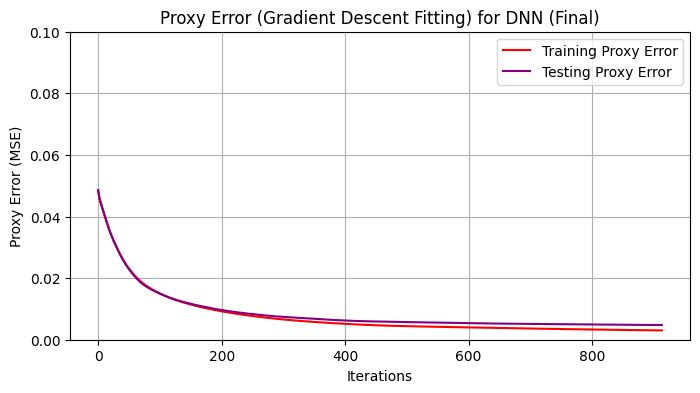

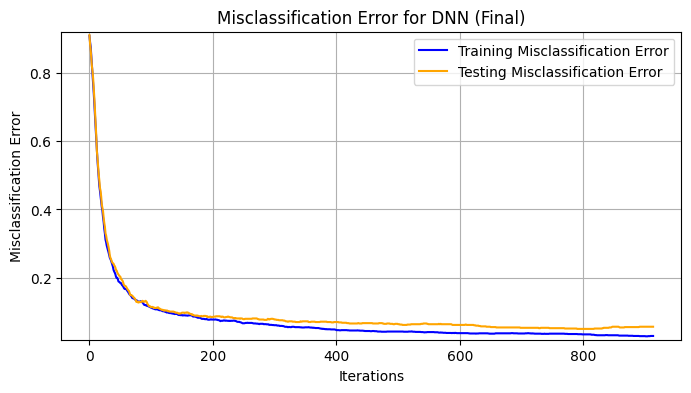

Final Test Error for DNN (Final): 0.05602536997885832


In [ ]:
  # Implemented by Zaynab Mourtada
  nnet_dnn, opt_dnn = dnn_model(*best_dnn_params)
  train_evaluate_model(nnet_dnn, opt_dnn, X, y_ohe, X_test, y_test_ohe, model_name="DNN (Final)")

(np.float64(0.19204057827235133), np.float64(0.8841778697001034))
0
Backprop...
done.
Update...
done.
(np.float64(0.05056903385018283), np.float64(0.9033092037228542))
max_change
0.8313067992014764
(test_err,test_err_rate)
(np.float64(0.05011490925944808), np.float64(0.8858350951374208))
1
Backprop...
done.
Update...
done.
(np.float64(0.06678696467099401), np.float64(0.8976215098241985))
max_change
0.24634720806078508
(test_err,test_err_rate)
(np.float64(0.06685365383118234), np.float64(0.897463002114165))
2
Backprop...
done.
Update...
done.
(np.float64(0.04964226875835431), np.float64(0.8712512926577043))
max_change
0.5155354364768236
(test_err,test_err_rate)
(np.float64(0.04950931976534272), np.float64(0.8636363636363636))
3
Backprop...
done.
Update...
done.
(np.float64(0.046448315659209524), np.float64(0.8852119958634953))
max_change
0.2057259177210529
(test_err,test_err_rate)
(np.float64(0.04677196206079561), np.float64(0.8995771670190275))
4
Backprop...
done.
Update...
done.
(np.f

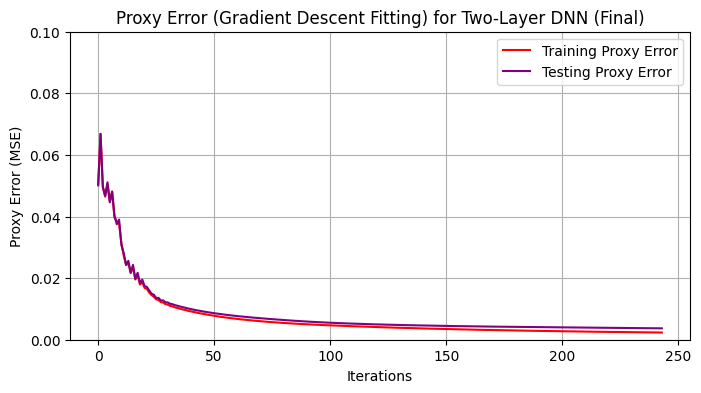

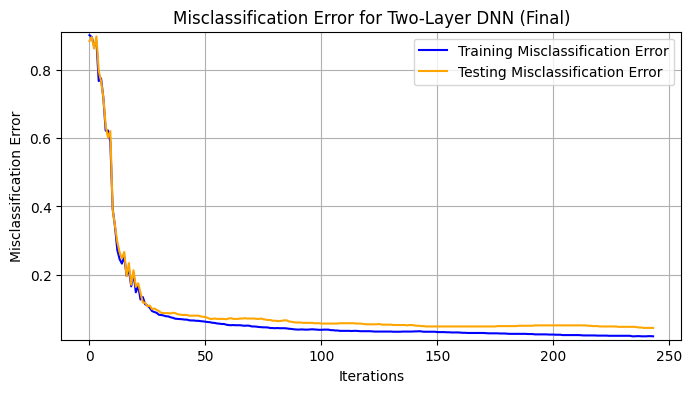

Final Test Error for Two-Layer DNN (Final): 0.04334038054968292


In [ ]:
  # Implemented by Zaynab Mourtada
  nnet_2l, opt_2l = dnn_two_layer_model(*best_two_layer_params)
  train_evaluate_model(nnet_2l, opt_2l, X, y_ohe, X_test, y_test_ohe, model_name="Two-Layer DNN (Final)")

In [ ]:
  # Implemented by Zaynab Mourtada
  trial_err_perceptron = evaluate_on_trial(nnet_p, X_trial, y_trial, "Perceptron")
  trial_err_dnn =  evaluate_on_trial(nnet_dnn, X_trial, y_trial, "DNN")
  trial_err_2layers = evaluate_on_trial(nnet_2l, X_trial, y_trial, "Two-Layer DNN")

Perceptron - Trial Set Misclassification Error: 0.0000
DNN - Trial Set Misclassification Error: 0.1000
Two-Layer DNN - Trial Set Misclassification Error: 0.0000



--- Perceptron Learning Curves ---


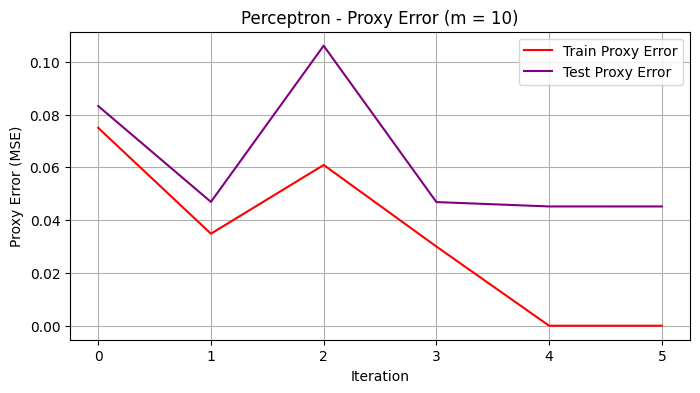

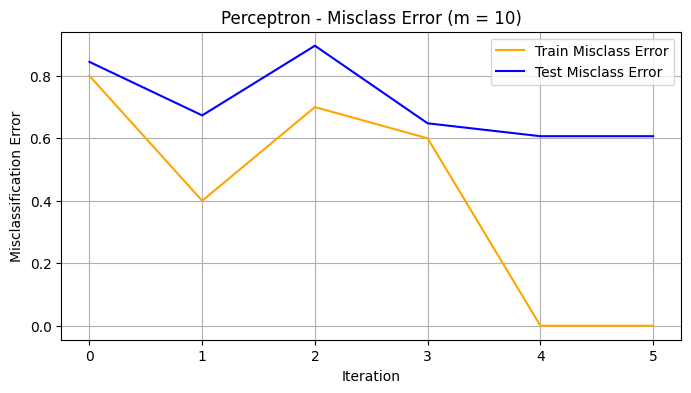

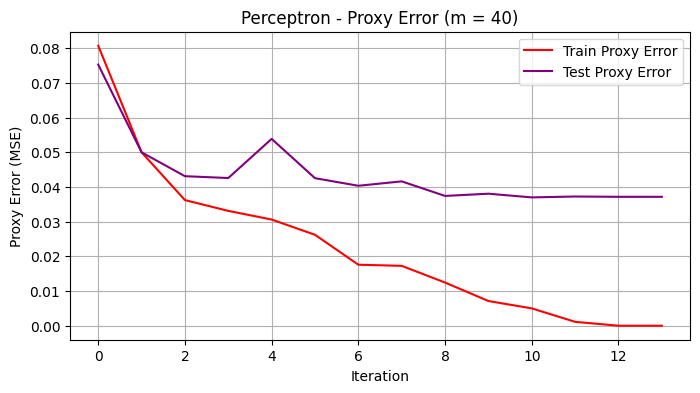

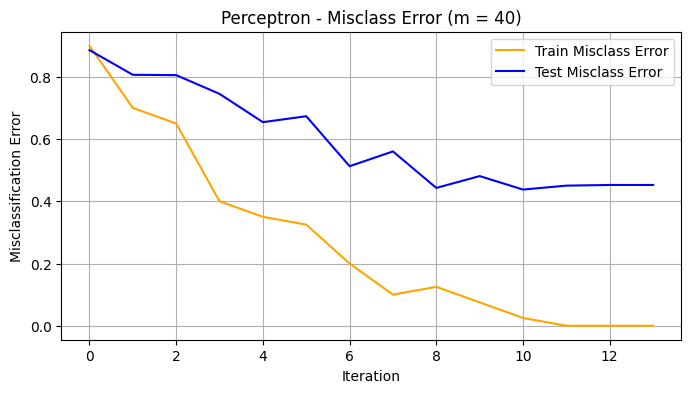

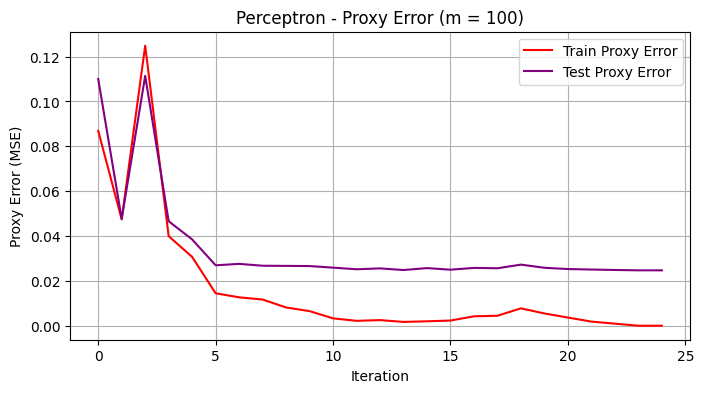

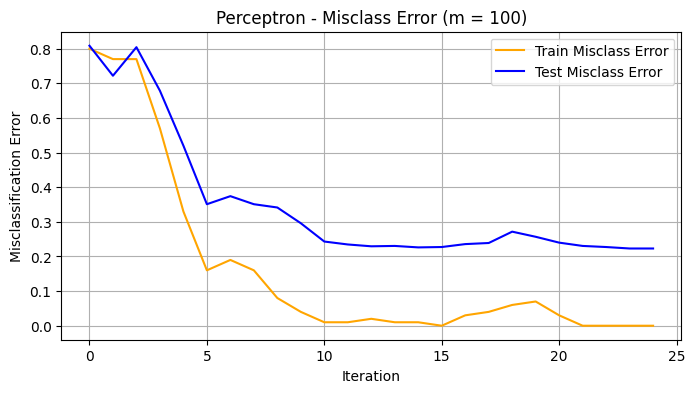

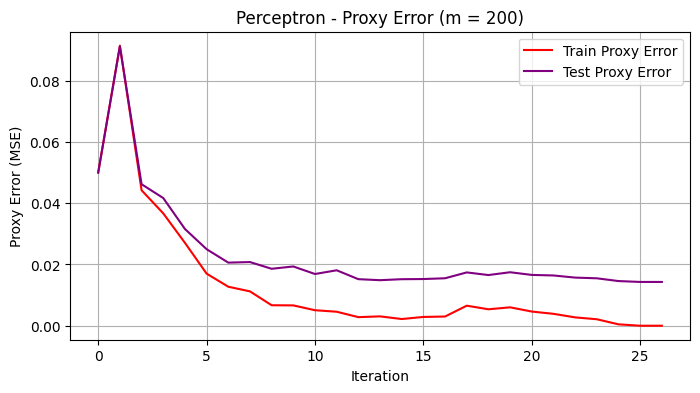

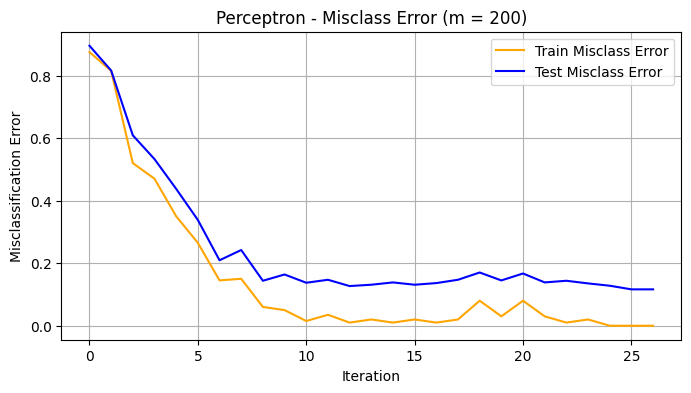

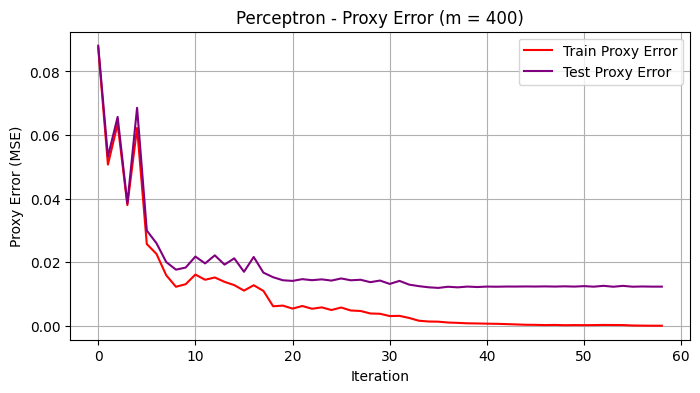

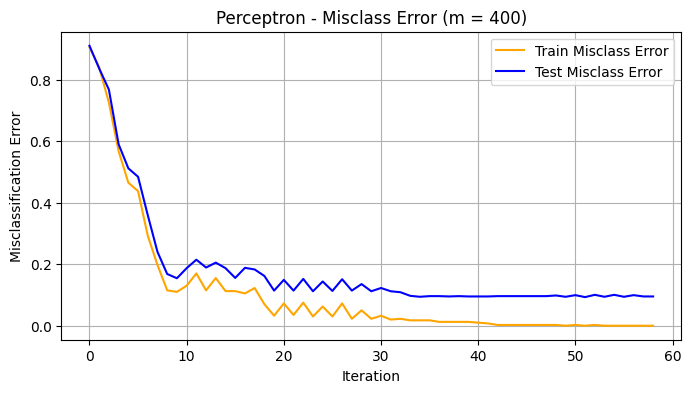

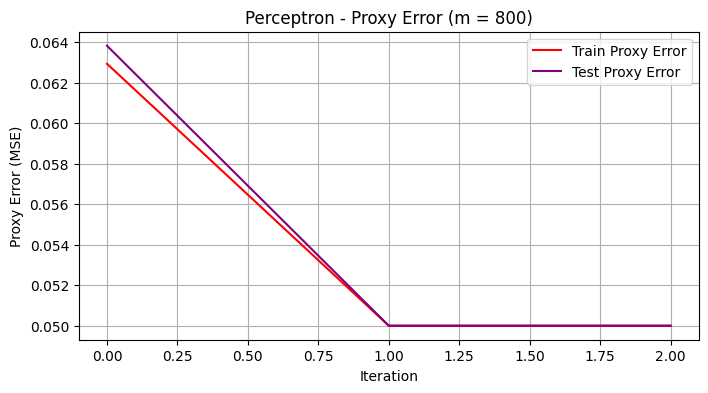

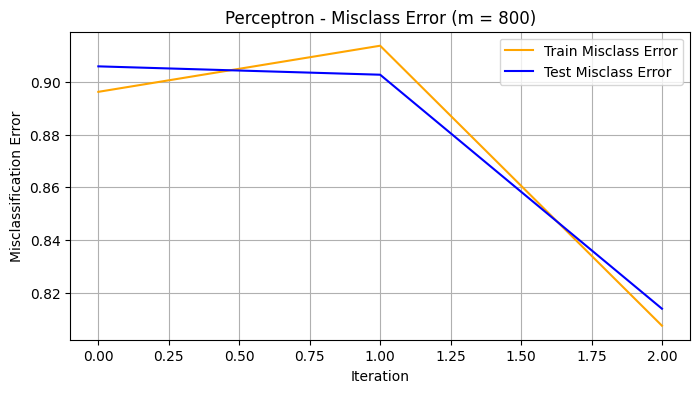

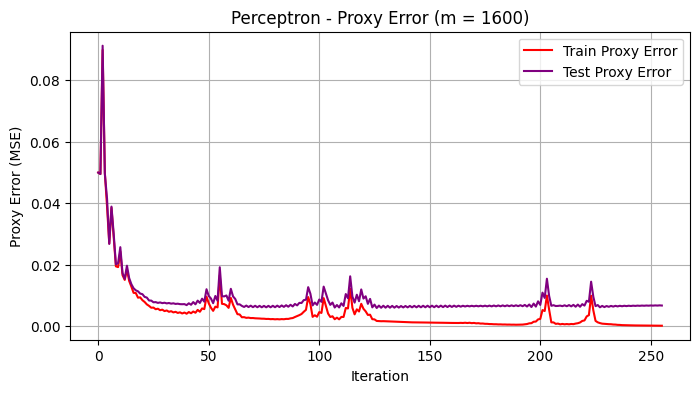

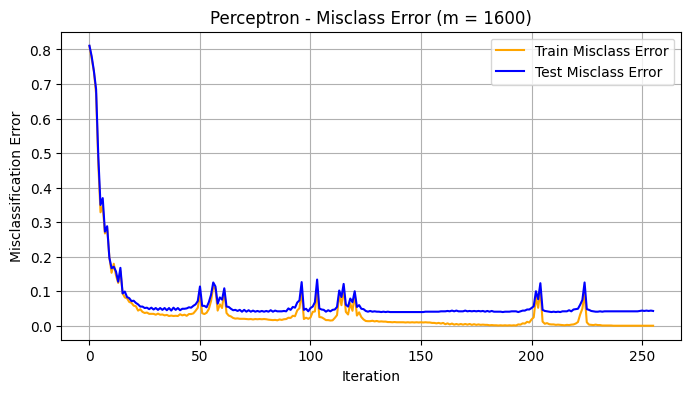

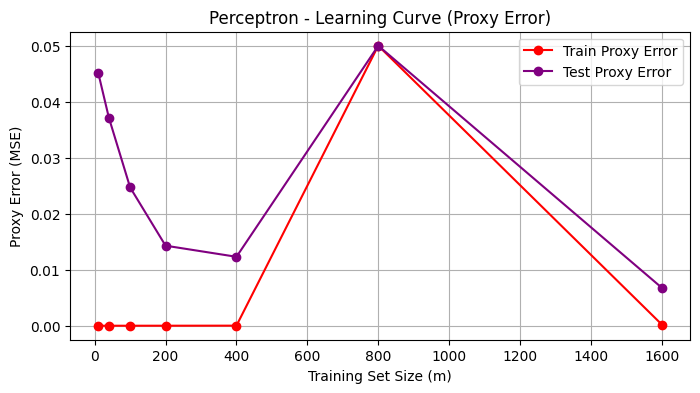

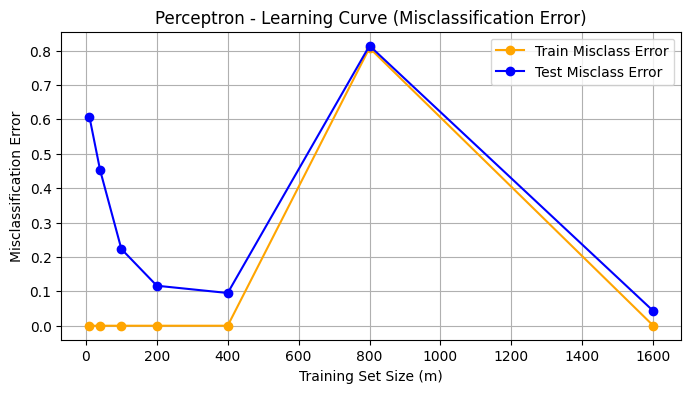


--- DNN Learning Curves ---


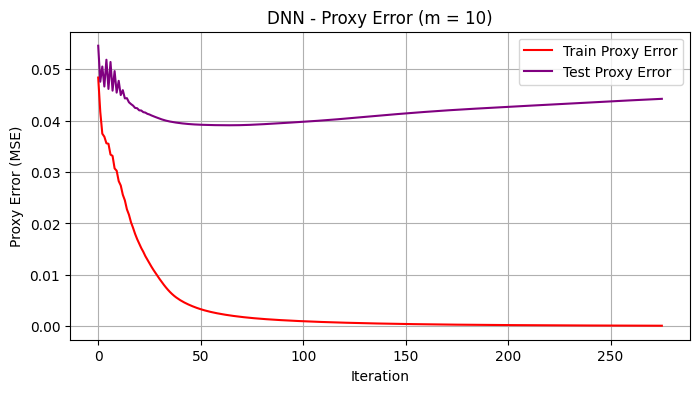

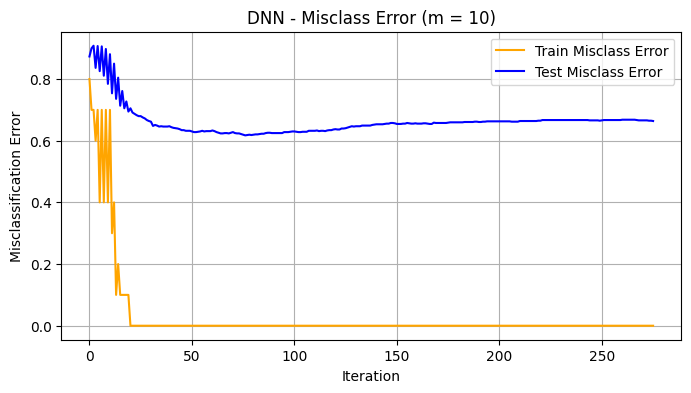

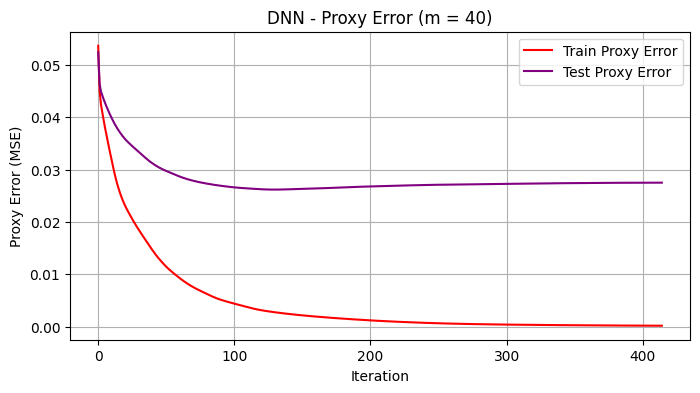

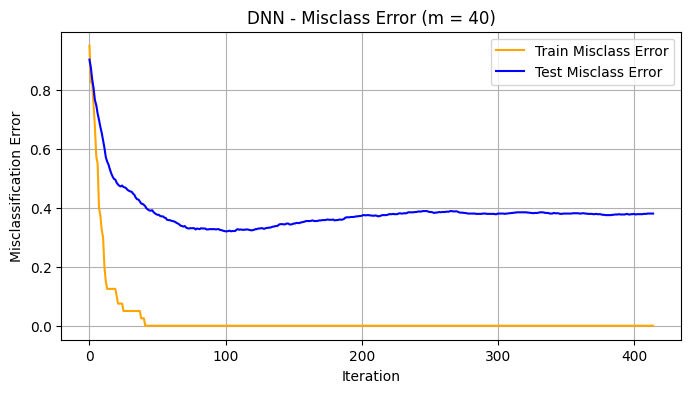

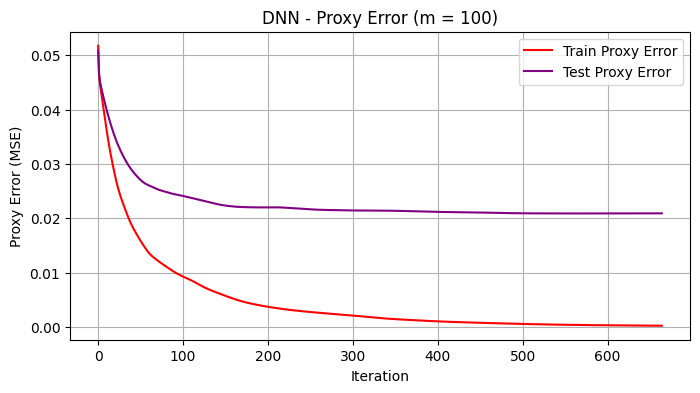

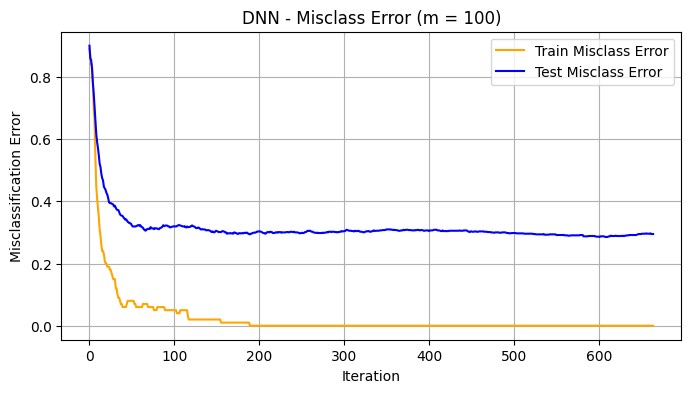

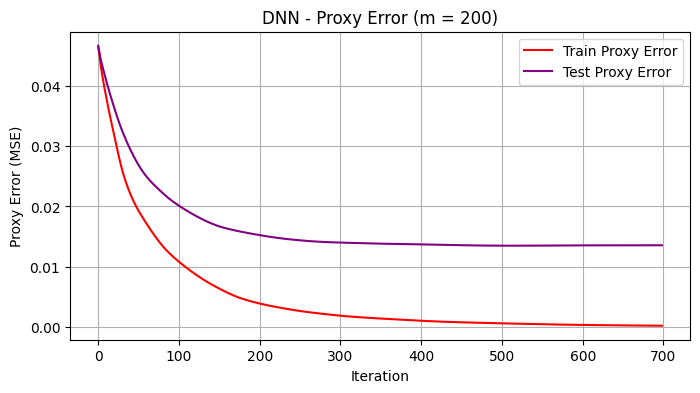

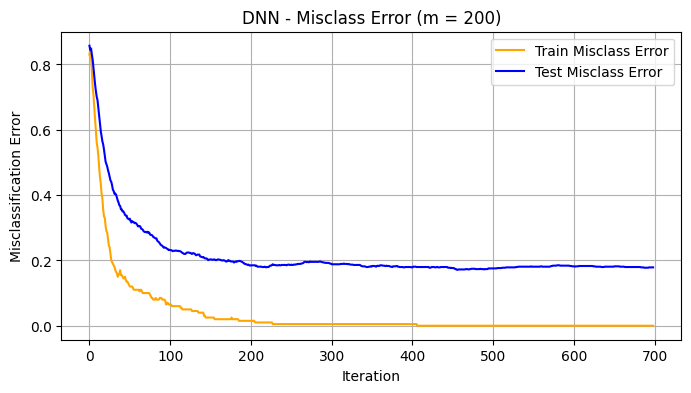

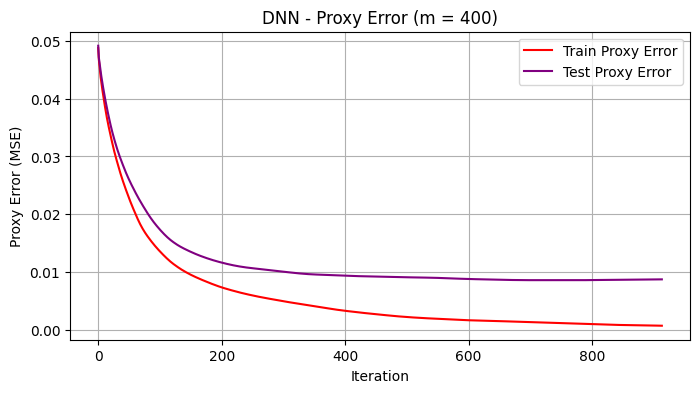

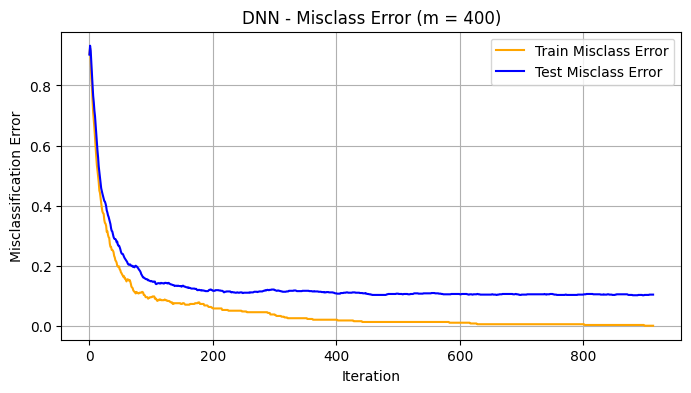

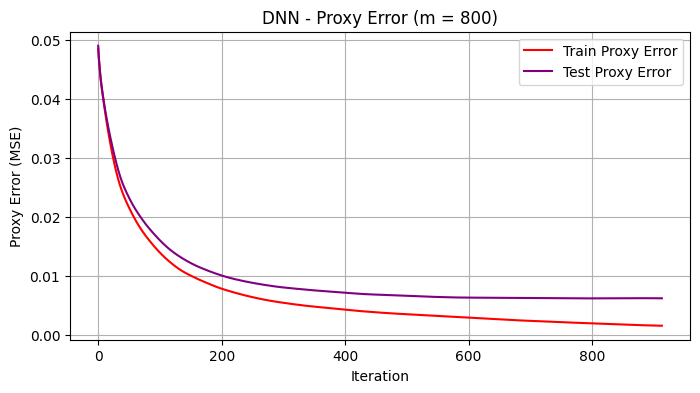

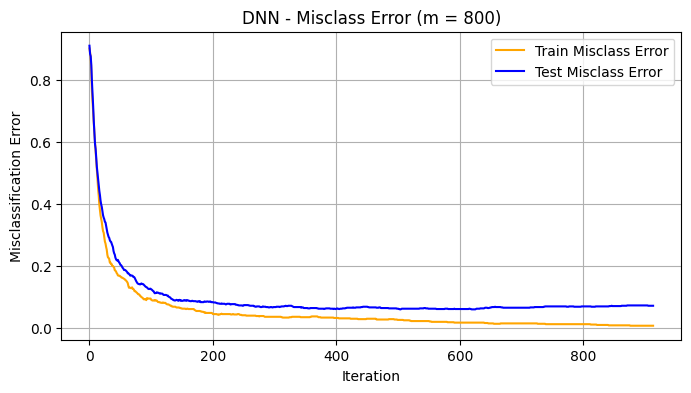

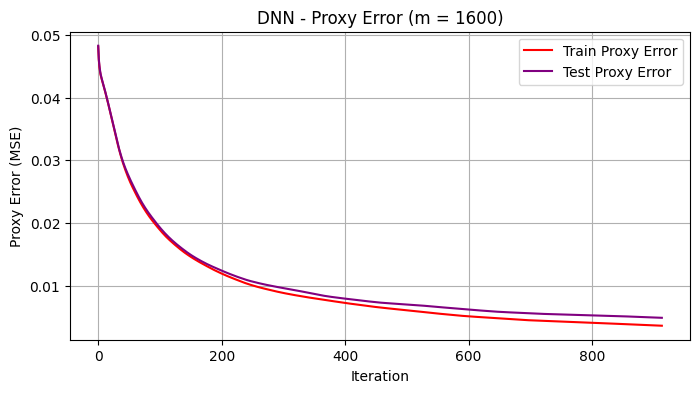

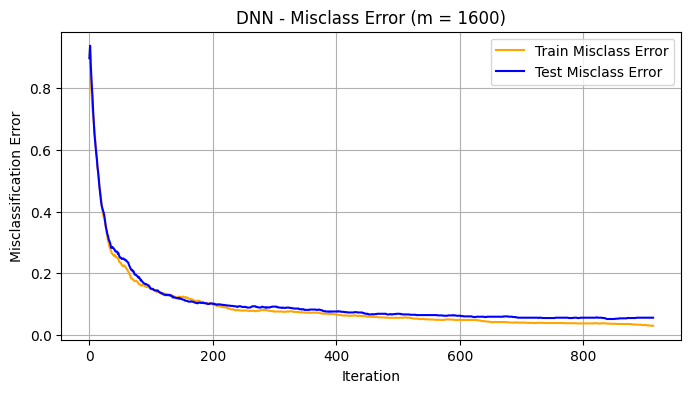

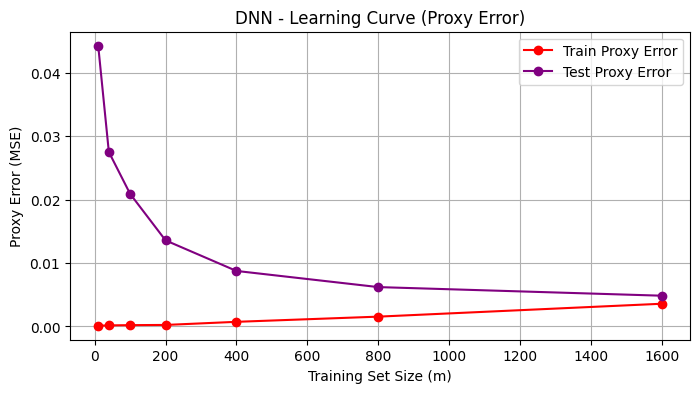

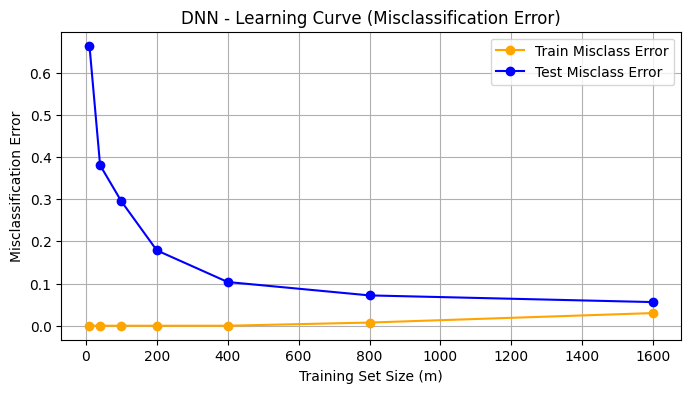


--- Two-Layer DNN Learning Curves ---


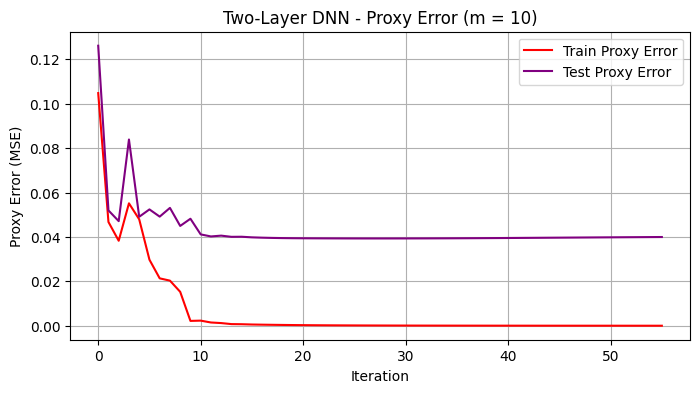

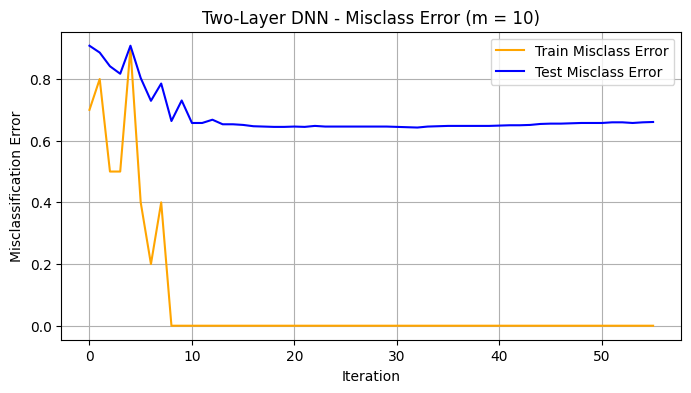

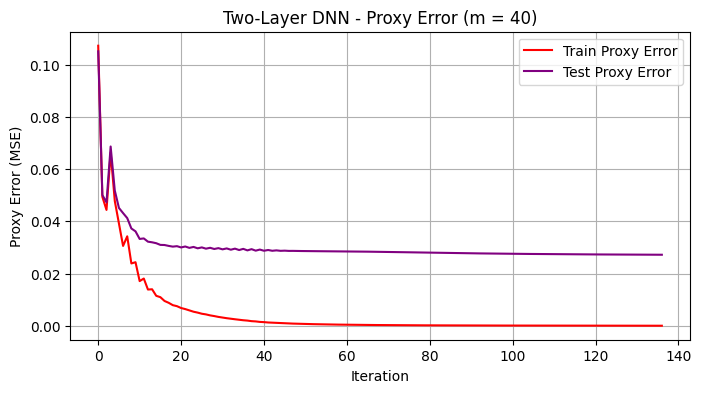

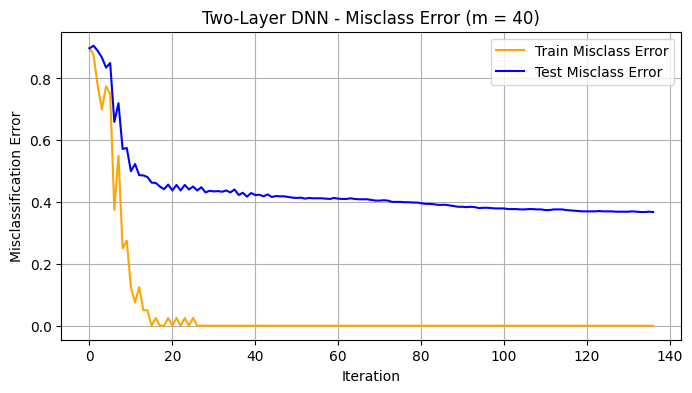

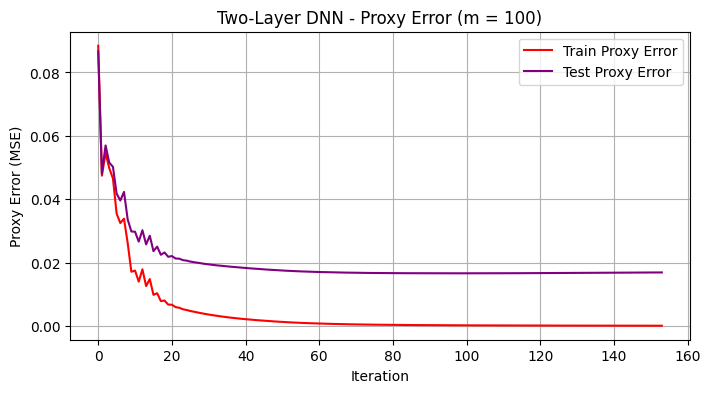

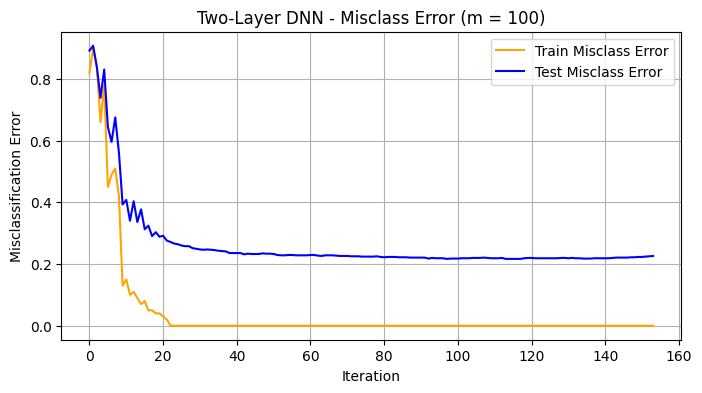

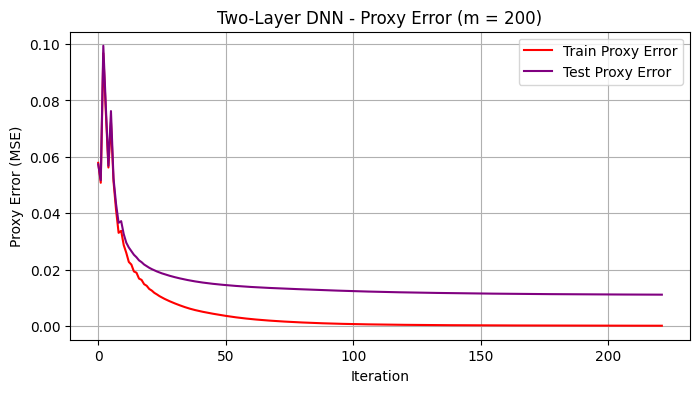

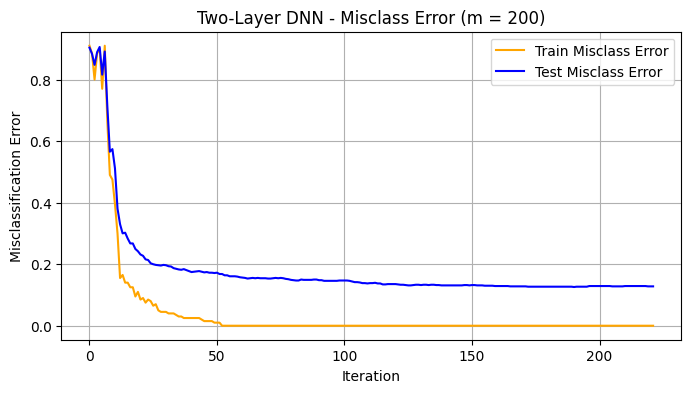

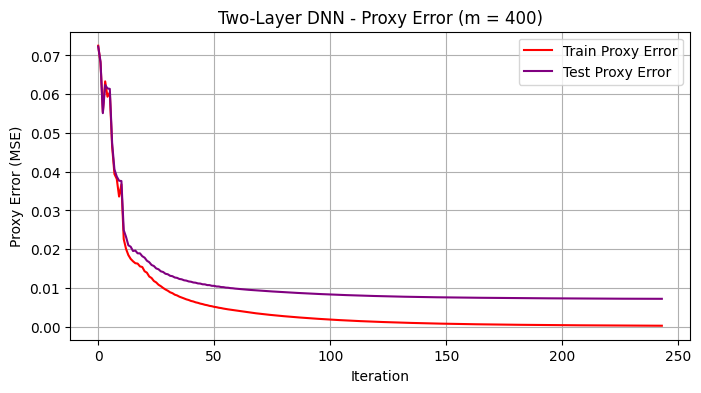

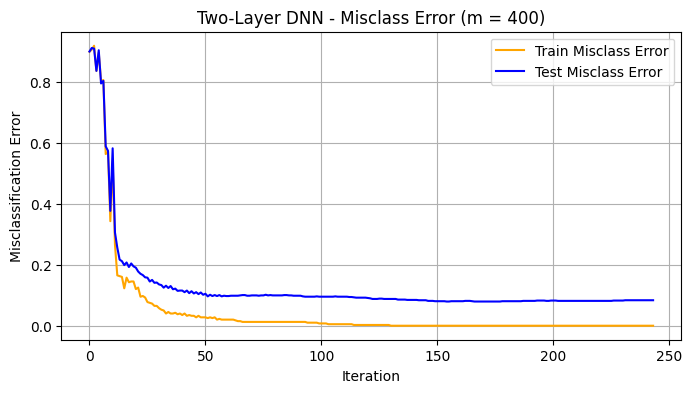

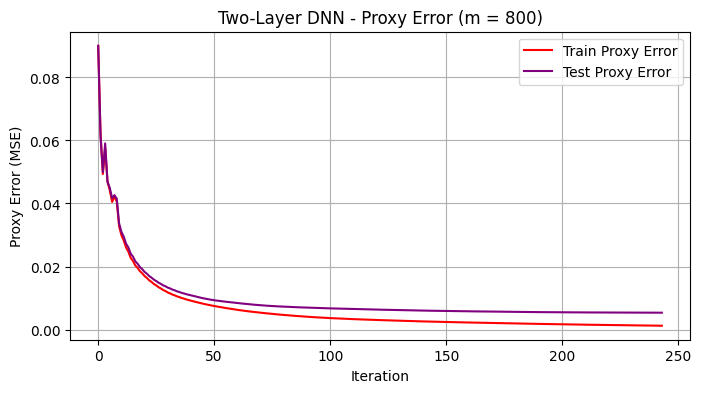

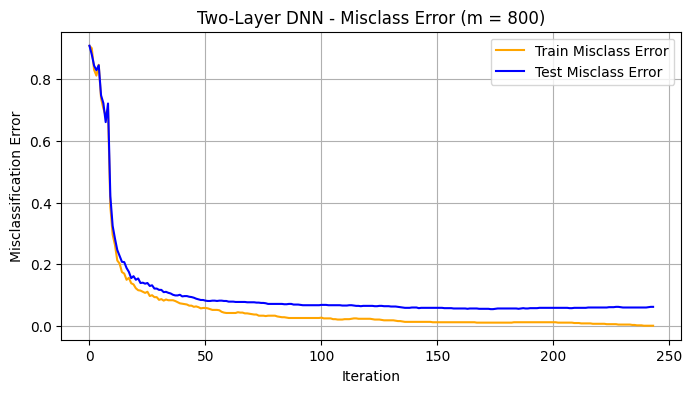

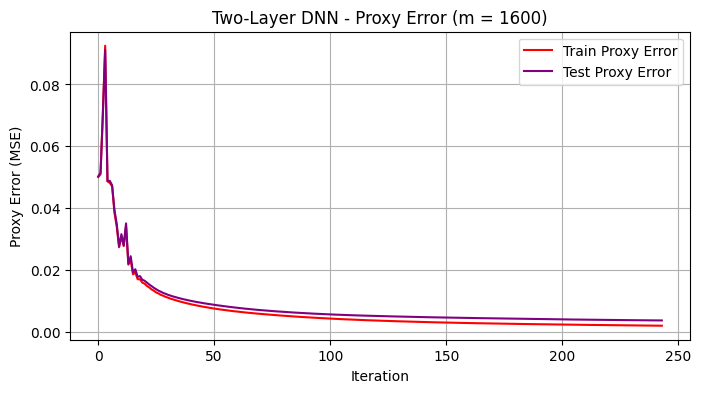

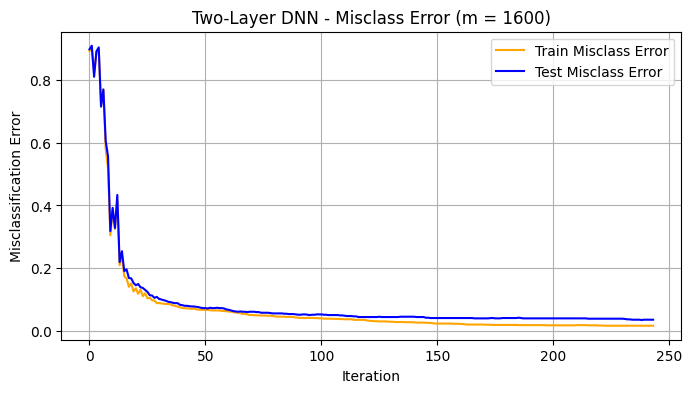

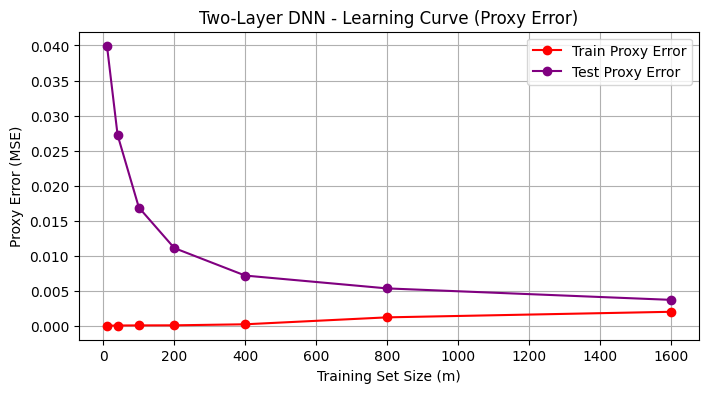

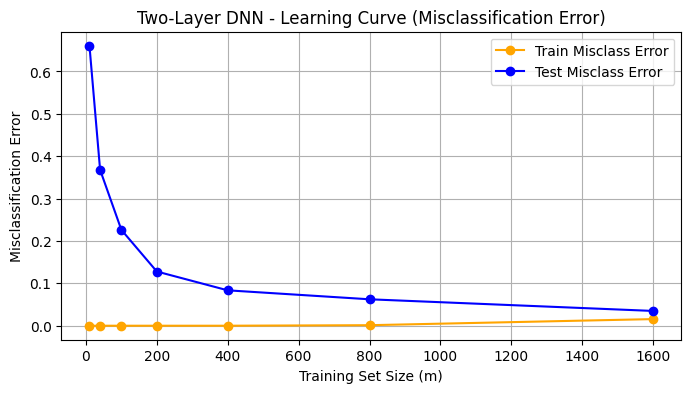

In [ ]:
  # Implemented by Zaynab Mourtada
  subset_sizes = [10, 40, 100, 200, 400, 800, 1600]
  models = {
      "Perceptron": {
          "model_fn": perception_model,
          "best_params": best_perceptron_params
      },
      "DNN": {
          "model_fn": dnn_model,
          "best_params": best_dnn_params
      },
      "Two-Layer DNN": {
          "model_fn": dnn_two_layer_model,
          "best_params": best_two_layer_params
      }
  }

  for model_name, model_info in models.items():
      train_proxy_errors = []
      test_proxy_errors = []
      train_misclass_errors = []
      test_misclass_errors = []

      print(f"\n--- {model_name} Learning Curves ---")

      for m_sub in subset_sizes:
          X_sub = X[:m_sub]
          y_sub = y_ohe[:m_sub]

          nnet, optimizer = model_info["model_fn"](*model_info["best_params"])
          nnet.fit(X_sub, y_sub, X_test, y_test_ohe, optimizer=optimizer, verbose=0)

          train_err = np.array(optimizer.train_err)
          test_err = np.array(optimizer.test_err)

          train_proxy_errors.append(train_err[-1, 0])
          test_proxy_errors.append(test_err[-1, 0])
          train_misclass_errors.append(train_err[-1, 1])
          test_misclass_errors.append(test_err[-1, 1])

          iterations = list(range(len(train_err)))

          # Proxy error plot per m
          plt.figure(figsize=(8, 4))
          plt.plot(iterations, train_err[:, 0], color='red', label='Train Proxy Error')
          plt.plot(iterations, test_err[:, 0], color='purple', label='Test Proxy Error')
          plt.xlabel("Iteration")
          plt.ylabel("Proxy Error (MSE)")
          plt.title(f"{model_name} - Proxy Error (m = {m_sub})")
          plt.legend()
          plt.grid(True)
          plt.show()

          # Misclassification error plot per m
          plt.figure(figsize=(8, 4))
          plt.plot(iterations, train_err[:, 1], color='orange', label='Train Misclass Error')
          plt.plot(iterations, test_err[:, 1], color='blue', label='Test Misclass Error')
          plt.xlabel("Iteration")
          plt.ylabel("Misclassification Error")
          plt.title(f"{model_name} - Misclass Error (m = {m_sub})")
          plt.legend()
          plt.grid(True)
          plt.show()

      # Learning curves over all subset sizes
      plt.figure(figsize=(8, 4))
      plt.plot(subset_sizes, train_proxy_errors, label='Train Proxy Error', color='red', marker='o')
      plt.plot(subset_sizes, test_proxy_errors, label='Test Proxy Error', color='purple', marker='o')
      plt.title(f"{model_name} - Learning Curve (Proxy Error)")
      plt.xlabel("Training Set Size (m)")
      plt.ylabel("Proxy Error (MSE)")
      plt.legend()
      plt.grid(True)
      plt.show()

      plt.figure(figsize=(8, 4))
      plt.plot(subset_sizes, train_misclass_errors, label='Train Misclass Error', color='orange', marker='o')
      plt.plot(subset_sizes, test_misclass_errors, label='Test Misclass Error', color='blue', marker='o')
      plt.title(f"{model_name} - Learning Curve (Misclassification Error)")
      plt.xlabel("Training Set Size (m)")
      plt.ylabel("Misclassification Error")
      plt.legend()
      plt.grid(True)
      plt.show()



In [ ]:
  print(n)
  print(K)
  print(m)
  print(m_test)

  nunits = [n, 512, 512, 512, 512, K]
  nnet_time = time_nnet(nunits)
  R = min(1000, math.ceil(MAX_TIME / (m * nnet_time)))
  nnet = NNet(nunits=nunits)

  opt = NNetGDOptimizer(metric=nnet_metric, max_iters=R, learn_rate=1)

  # best_nnet = nnet.fit(X[:1000,:],y_ohe[:1000,:],X_test,y_test_ohe,optimizer=opt,verbose=1)
  best_nnet = nnet.fit(X,y_ohe,X_test,y_test_ohe,optimizer=opt,verbose=1)

In [ ]:
  train_err, test_err = np.array(opt.train_err), np.array(opt.test_err)

  print(test_err[-1,1])

  plt.plot(train_err[:,0])
  plt.plot(test_err[:,0])
  plt.show()

  plt.plot(train_err[:,1])
  plt.plot(test_err[:,1])
  plt.show()

In [ ]:
  plt.imshow(best_nnet.layer[1].W[0,1:].reshape(32,32))

In [ ]:
  n_hidu = 128 # 512
  n_hidl = 2

  nunits = make_nunits(n,K,n_hidl,n_hidu)
  nnet_time = time_nnet(nunits)

  R = min(1000,math.ceil(MAX_TIME / (m * nnet_time)))

  print(R)

458


In [ ]:
n_hidu = 128 # 512
n_hidl = 2

nunits = [1024, 512, 256, 128, 64, 10]
nnet_time = time_nnet(nunits)

R = min(1000,math.ceil(MAX_TIME / (m * nnet_time)))

print(R)

98


In [ ]:
  # opt = NNetGDOptimizer(metric=nnet_metric, max_iters=400, learn_rate=0.5**8)
  opt = NNetGDOptimizer(metric=nnet_metric, max_iters=R, learn_rate=2**-1, change_err_thresh=0, change_thresh=0)

  # nnet = NNet(nunits=[1024, 512, 512, 10],unit=NNetActivation(identity,deriv_identity),output_unit=NNetActivation(sigmoid,deriv_sigmoid))
  nnet = NNet(nunits=nunits)

  best_nnet = nnet.fit(X,y_ohe,X_test,y_test_ohe,optimizer=opt,verbose=1)
  # est_nnet = nnet.fit(X,y_ohe,optimizer=opt,verbose=1)

In [ ]:
  train_err, test_err = np.array(opt.train_err), np.array(opt.test_err)

  print(test_err[-1,1])

  plt.plot(train_err[:,0])
  plt.plot(test_err[:,0])
  plt.show()

  plt.plot(train_err[:,1])
  plt.plot(test_err[:,1])
  plt.show()

In [ ]:
  plt.imshow(best_nnet.layer[1].W[10,1:].reshape(32,32))

In [ ]:
  plt.imshow(np.absolute(best_nnet.layer[2].W[:,1:]))